# Finding the requisite N for reliable site-level inclination corrections (e.g. PmagPy's find_EI)

Paleomagnetic and other directional data are susceptible to inclination error. Inclination error affects the "steepness" of directions, leading to exaggerated elongation of their distribution. For example, the detrital magnetic remanence contained in sedimentary strata may become squished or compacted as the rock is lithified. 

In paleomagnetism, one correction for inclination error gradually "unsquishes" the directional data and tests for a mean inclination/elongation pair consistent with some geomagnetic field model. This is effective for data at the study-level, since secular variation of the geomagnetic field **over geologic time** will result in *some* elongation of data depending on the paleolatitude and corresponding inclination of the directional data. At the site-level, on the other hand, in which all data represents a virtually instantaneous moment in geologic time (like a snapshot of the geomagnetic field), we expect data to be equally distributed (minimal elongation) and thereby consistent with a Fisher distribution. So, correcting for inclination error *by site* consists of finding the (un)flattening factor that brings the data to a minimized elongation, rather than a comparison with a model. 

In the latter case of a site-level correction, there is a minimum number of samples per site (N) that are required for the correction to be reliable. This notebook demonstrates ways to estimate N, especially as it applies to the **find_EI** PmagPy function. The first section is concerned with the requisite N to identify a dataset that needs to be corrected for inclination error. It addresses the question "How many samples are needed to confidently distinguish a squished Fisher distribution (which needs correcting) from an unsquished Fisher distribution?".

The second section is a more direct test of the PmagPy function **find_EI**. It consists of a Monte Carlo simulation that tests the accuracy of find_EI at random N's. 

In [1]:
import pmagpy.ipmag as ipmag
import pmagpy.pmagplotlib as pmagplotlib
import pmagpy.pmag as pmag

from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from scipy.optimize import curve_fit
from IPython.display import clear_output
from ipywidgets import interact
%matplotlib inline

/Users/lukefairchild765/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Necessary number of samples to confidently tell whether your data has been squished

The primary objective of having a requisite N for a particular site is to make sure we can reliably distinguish between Fisher distributed data that have and have not been squished. This is the most basic test that our correction needs to pass -- it is more a check on our observation and interpretation of data. This should tell us whether directions we may see as "squished" could actually have been drawn from a regular Fisher distribution. 

In [2]:
# %%time
# # uncomment to run Monte Carlo model (takes a long time) -- results of n=3000
# # model already run have been stored in csv file
# test_table = pd.DataFrame(columns=['N', 'f', 'Fisher', 'kappa', 'inc_org'])

# # k range = 5-80 ??? maybe should further randomize this based on resultant a95
# b = 0
# iterator = 0
# nb = 3000

# while b < nb:
#     if b%5==0:
#         clear_output()
#     print b, "out of", nb
#     sys.stdout.flush()
#     for flat in np.arange(0.1, 1, 0.05):
#         kappa = np.random.choice(np.arange(5,80,5))
# #         k=20
#         n = np.random.randint(11, 500)
#         inc_org=np.random.randint(0,90)
#         decs, incs = ipmag.fishrot(inc = inc_org,k=kappa, n=n, di_block=False)
#         squished_incs = ipmag.squish(incs, flat)
#         try:
#             fisher_test = ipmag.fishqq(decs, squished_incs)
#         except:
#             decs, squished_incs
#         try:
#             if fisher_test['Test_result'] == 'Fisherian model rejected':
#                 passed = False
#             elif fisher_test['Test_result'] == 'consistent with Fisherian model':
#                 passed = True
#         except TypeError: # returned two modes (not unimodal Fisher distribution)
#             passed = False
#         test_table.loc[iterator,['N', 'f', 'Fisher', 'kappa', 'inc_org']] = [n, flat, passed, kappa, inc_org]
#         iterator += 1
#         plt.show()
#     b += 1

In [3]:
# test_table.to_csv('./n3000new.csv')
test_table = pd.read_csv('./n3000new.csv', index_col=0)
#test_table = pd.read_csv('./n1000.csv', index_col=0)

In [4]:
test_table = test_table.sort_values(by='kappa', ascending=False)
test_table = test_table.reset_index(drop=True)
test_table.head()

,N,f,Fisher,kappa,inc_org
0,412,0.25,False,75,11
1,339,0.95,True,75,38
2,419,0.20,False,75,38
3,90,0.55,True,75,73
4,449,0.75,False,75,15


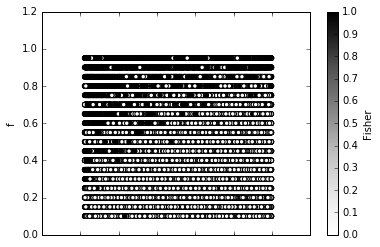

In [5]:
# line separating the True and False datapoints 
# should give the necessary number of samples per site 
# needed for a proper unflattening correction
test_table.plot.scatter('N', 'f', c='Fisher')
plt.show()

In [6]:
test_fail = test_table.loc[test_table['Fisher']==False]
test_pass = test_table.loc[test_table['Fisher']==True]

Below we compare a scatterplot of correctly interpretted distributions of a particular N and flattening factor f (correctly interpretted = not consistent with Fisher distribution, as these are squished directions) with incorrectly interpretted distributions (squished Fisher distributions that were mistaken by ipmag.fishqq for Fisher distributions). 

The first plot indicates that all possible distributions of a particular N, f, and $\kappa$ have a possibility of failing a Fisher distribution test after being squished (as should be expected). The second plot indicates that it is equally possible for most of these squished distributions to incorrectly *pass* a Fisher distribution test. However, at each f, there is a minimum N at which passing a Fisher distribution test becomes virtually impossible. This N value (dependent on both f and $\kappa$) is our requisite N for inclination correction by site. 

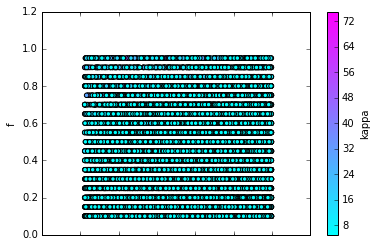

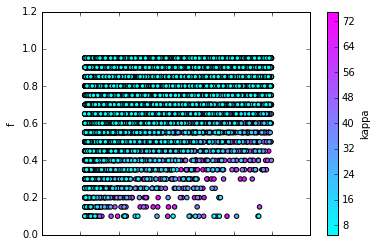

In [7]:
test_fail.plot.scatter('N', 'f', c='kappa', colormap='cool')
test_pass.plot.scatter('N', 'f', c='kappa',colormap='cool')
plt.show()

In [8]:
test_pass['kappa'].unique()

array([75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25, 20, 15, 10,  5])

So if flattening factor is calculated by find_EI to be approx. 0.2, it looks like about 75 samples would be required for confidence in the correction ($\kappa = 45$). The requisite number of samples apparently increases exponentially with flattening factor (meaning it increases exponentially with the inverse of the degree of flattening). As N goes up, although you can be more confident in your correction, the massive flood of datapoints is more easily mistaken for a Fisher distribution (unless you squish it severely). This all also has dependence on k of course (it is a free variable in reality, although a single value is chosen above).

Interestingly, the lower the concentration parameter k (higher dispersal), the fewer samples are needed to reliably distinguish between an original Fisher distribution and a squished one. 

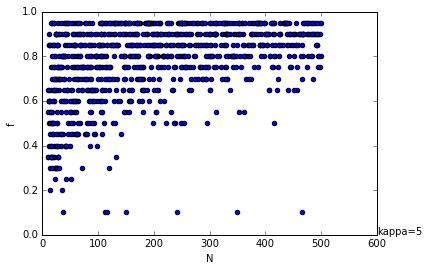

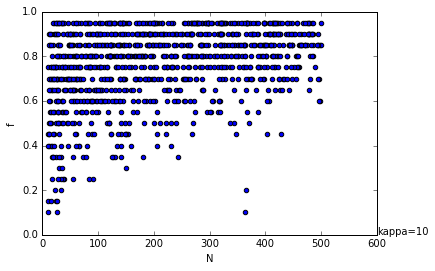

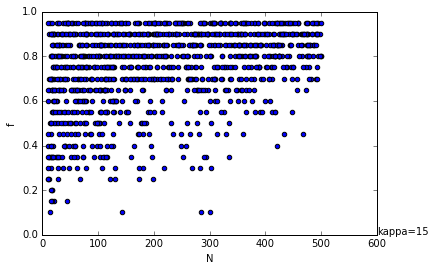

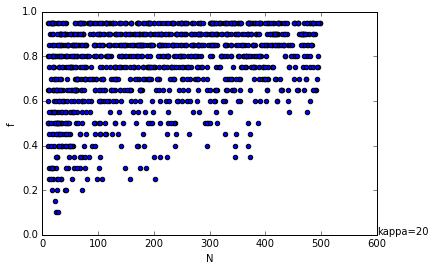

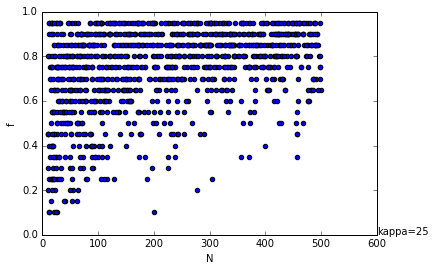

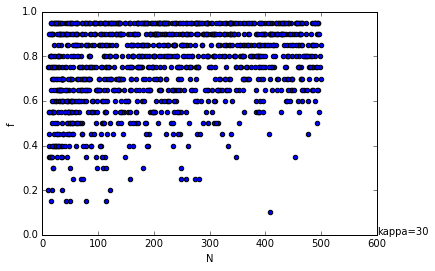

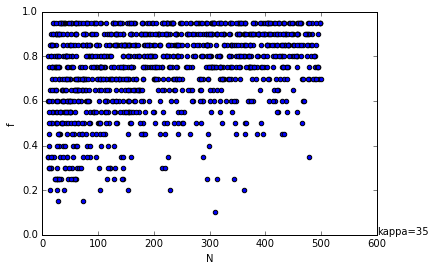

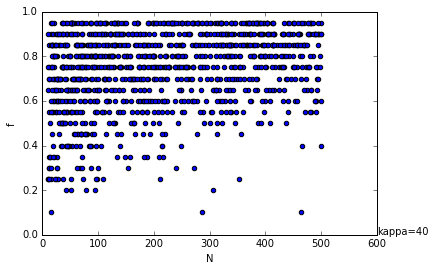

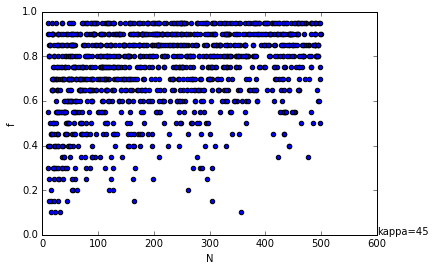

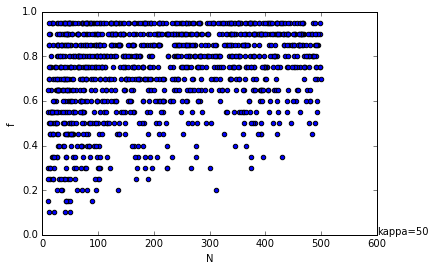

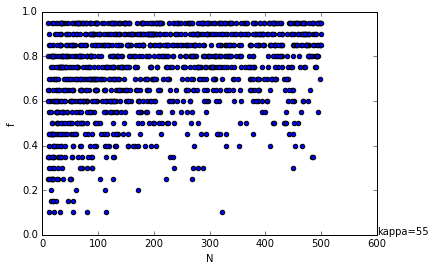

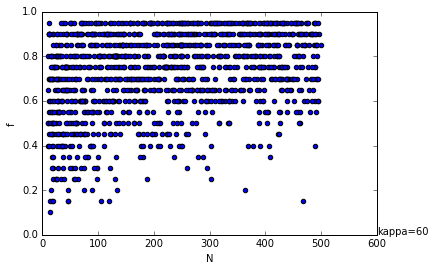

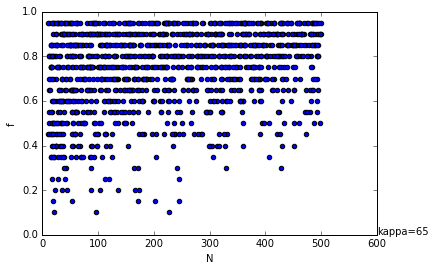

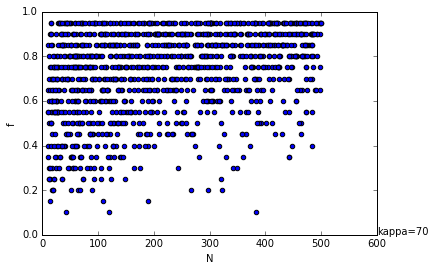

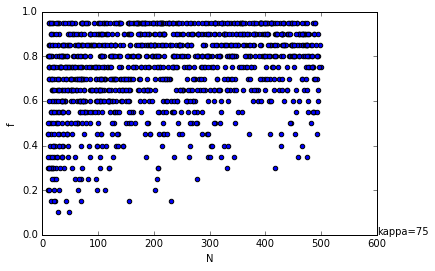

In [9]:
pass_dict = {}

for x in np.arange(5, 80, 5):
    pass_dict['test_pass_k{0}'.format(x)] = test_pass.loc[test_pass['kappa']==x]
    
for x in np.arange(5, 80, 5):
    pass_dict['test_pass_k{0}'.format(x)].plot.scatter('N', 'f', xlim=(0,600), ylim=(0.0,1.0))
    plt.text(1,0,'kappa=' + str(x), transform=plt.gca().transAxes)

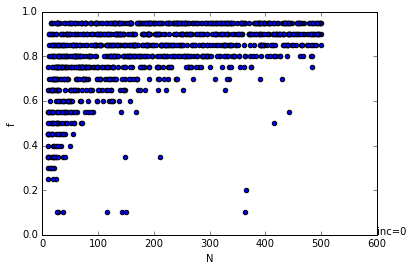

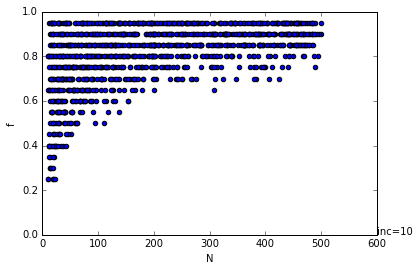

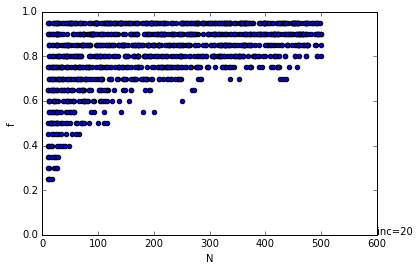

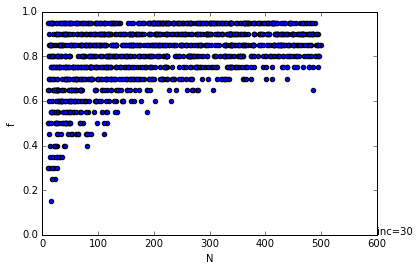

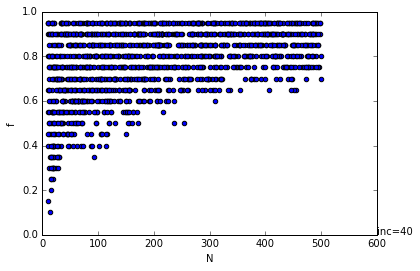

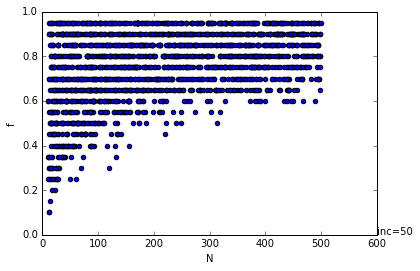

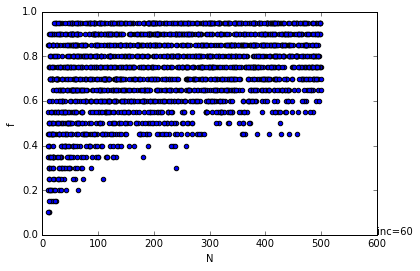

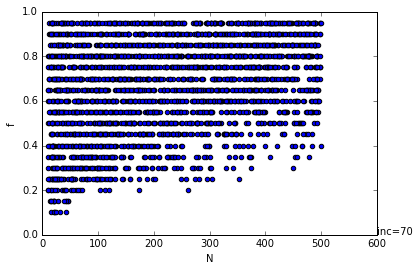

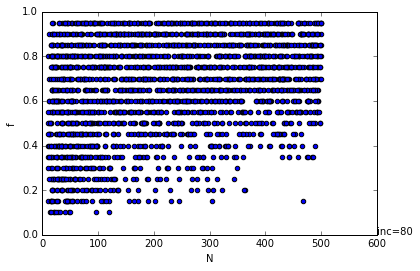

In [10]:
inc_dict = {}

for x in np.arange(0, 90, 10):
    inc_dict['test_pass_inc{0}'.format(x)] = test_pass.loc[test_pass['inc_org']>x].loc[test_pass['inc_org']<x+10]
    
for x in np.arange(0, 90, 10):
    inc_dict['test_pass_inc{0}'.format(x)].plot.scatter('N', 'f', xlim=(0,600), ylim=(0.0,1.0))
    plt.text(1,0,'inc=' + str(x), transform=plt.gca().transAxes)

In [11]:
inc_dict['test_pass_inc0'].head()

,N,f,Fisher,kappa,inc_org
132,119,0.60,True,75,1
154,353,0.90,True,75,2
287,187,0.85,True,75,6
316,397,0.95,True,75,1
341,36,0.80,True,75,3


In [15]:
for df in pass_dict.values():
    for f in df.f.unique():
        new_df = df.loc[df['f']==f]
        for inc in new_df.inc_org.unique():
            new_df2 = new_df.loc[new_df['inc_org']==inc]
            df_maxN = new_df2.loc[new_df2['N']==new_df2.N.max()]
            combined = combined.append(df_maxN, ignore_index=True)

In [16]:
@interact
def look(kappa=(5,75,5), inc_org=(0,90,10)):
    maxN_list = []
    k5 = combined.loc[combined['kappa']==kappa].loc[combined['N']<450]
    k5 = k5.loc[k5['inc_org']<(inc_org+10)].loc[k5['inc_org']>inc_org]
    for flat in k5.f.unique():
        maxN_list.append(k5.loc[k5['f']==flat].N.max())
    k5 = k5.ix[k5.f.unique()].loc[k5.N.max()]
#     k5.loc[k5['N']>=x] if x in maxN_list
    k5.plot.scatter('f', 'N', c='r')
#     elements, cov = curve_fit(ln, k5['N'].tolist(), k5['f'].tolist())

#     plt.ylim(0,500)
#     plt.xlim(0,90)
#     xdata = []
#     ydata = []
#     for x in np.arange(0,500):
#         xdata.append(x)
#         ydata.append(ln(x, elements[0], elements[1],elements[2]))

#     plt.plot(xdata, ydata)
    plt.ylim(0,500)
    plt.xlim(0,1)
    plt.show()
    
    fish_dirs = ipmag.fishrot(inc=inc_org, k=kappa)
    plt.figure(num=1,figsize=(5,5))
    ipmag.plot_net(1)
    ipmag.plot_di(di_block=fish_dirs)
    plt.show()

KeyError: 'the label [449.0] is not in the [index]'

In [17]:
combined = pd.DataFrame(columns=test_pass.keys())

In [18]:
for df in pass_dict.values():
    for f in df.f.unique():
        new_df = df.loc[df['f']==f]
        df_maxN = new_df.loc[new_df['N']==new_df.N.max()]
        combined = combined.append(df_maxN, ignore_index=True)

In [19]:
# for x in np.arange(5,80,5):
#     combined.loc[combined['kappa']==x].plot.scatter('N', 'f', c='kappa',colormap='Accent')

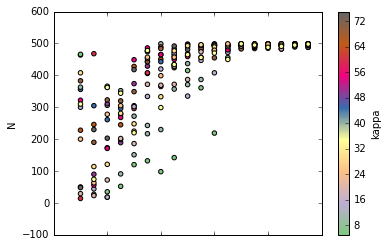

In [20]:
combined.plot.scatter('f', 'N', c='kappa',colormap='Accent')

In [21]:
# def ln(x, a, b):
#     return a * np.log(x) + b
def ln(x, a, b, c):
    return a * (x+b)**2 + c

(0, 1)

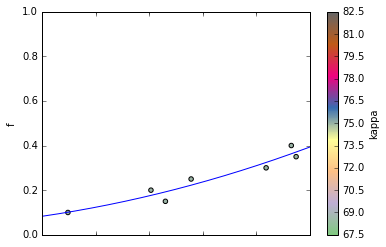

In [22]:
kappa_var = 75
k5 = combined.loc[combined['kappa']==kappa_var].loc[combined['N']<480]
k5.plot.scatter('N', 'f', c='kappa',colormap='Accent')
elements, cov = curve_fit(ln, k5['N'].tolist(), k5['f'].tolist())

xdata = []
ydata = []
for x in np.arange(0,500):
    xdata.append(x)
    ydata.append(ln(x, elements[0], elements[1], elements[2]))
    
plt.plot(xdata, ydata)
plt.xlim(0,500)
plt.ylim(0,1)

For $\kappa \approx$ {{kappa_var}}, $f(N) =$ {{elements[0]}} $*$ $\ln{N}$ $+ ${{elements[1]}}

In [23]:
@interact
def find_curve(kappa=(5,75,5), inc_org=(0,90,10)):
    k5 = combined.loc[combined['kappa']==kappa].loc[combined['N']<450]
    print k5
    k5 = k5.loc[k5['inc_org']<(inc_org+10)].loc[k5['inc_org']>inc_org]
    k5.plot.scatter('N', 'f', c='r')
    elements, cov = curve_fit(ln, k5['N'].tolist(), k5['f'].tolist())

    xdata = []
    ydata = []
    for x in np.arange(0,500):
        xdata.append(x)
        ydata.append(ln(x, elements[0], elements[1],elements[2]))

    plt.plot(xdata, ydata)
    plt.xlim(0,500)
    plt.ylim(0,1)
    plt.show()
    
    fish_dirs = ipmag.fishrot(k=kappa)
    plt.figure(num=1,figsize=(5,5))
    ipmag.plot_net(1)
    ipmag.plot_di(di_block=fish_dirs)
    plt.show()

        N     f Fisher  kappa  inc_org
21  272.0  0.30   True   40.0     79.0
22  352.0  0.25   True   40.0     79.0
28  437.0  0.50   True   40.0     82.0
32  217.0  0.35   True   40.0     81.0
33  357.0  0.45   True   40.0     71.0
34  306.0  0.20   True   40.0     81.0


TypeError: Empty 'DataFrame': no numeric data to plot

## Monte Carlo simulation directly testing the function ipmag.find_EI( )

In [24]:
#define bare bones find_EI
def find_EI(data, nb=1000, save = False, save_folder = '.', fmt='svg',
            site_correction = False, return_new_dirs = False):
    """
    Applies series of assumed flattening factor and "unsquishes" inclinations assuming tangent function.
    Finds flattening factor that gives elongation/inclination pair consistent with TK03;
    or, if correcting by site instead of for study-level secular variation,
    finds flattening factor that minimizes elongation and most resembles a
    Fisherian distribution.
    Finds bootstrap confidence bounds

    Arguments
    -----------
    data: a nested list of dec/inc pairs

    Keywords
    -----------
    nb: number of bootstrapped pseudo-samples (default is 1000)
    save: Boolean argument to save plots (default is False)
    save_folder: path to folder in which plots should be saved (default is current directory)
    fmt: specify format of saved plots (default is 'svg')
    site_correction: Boolean argument to specify whether to "unsquish" data to
        1) the elongation/inclination pair consistent with TK03 secular variation model
        (site_correction = False)
        or
        2) a Fisherian distribution (site_correction = True). Default is FALSE.
        Note that many directions (~ 100) are needed for this correction to be reliable.
    return_new_dirs: optional return of newly "unflattened" directions (default is False)

    Output
    -----------
    four plots:   1) equal area plot of original directions
                  2) Elongation/inclination pairs as a function of f,  data plus 25 bootstrap samples
                  3) Cumulative distribution of bootstrapped optimal inclinations plus uncertainties.
                     Estimate from original data set plotted as solid line
                  4) Orientation of principle direction through unflattening

    NOTE: If distribution does not have a solution, plot labeled: Pathological.  Some bootstrap samples may have
       valid solutions and those are plotted in the CDFs and E/I plot.
    """

    upper,lower=int(round(.975*nb)),int(round(.025*nb))
    E,I=[],[]

    ppars=pmag.doprinc(data)
    Io=ppars['inc']
    n=ppars['N']
    Es,Is,Fs,V2s=pmag.find_f(data)
    if Fs[-1]==0:
        raise Exception
    if site_correction == True:
        Inc,Elong=Is[Es.index(min(Es))],Es[Es.index(min(Es))]
        flat_f = Fs[Es.index(min(Es))]
    else:
        Inc,Elong=Is[-1],Es[-1]
        flat_f = Fs[-1]
    b=0

    while b < nb:
        bdata = pmag.pseudo(data)
        Esb,Isb,Fsb,V2sb = pmag.find_f(bdata)
        if Esb[-1] != 0:
            ppars=pmag.doprinc(bdata)
            if site_correction == True:
                I.append(abs(Isb[Esb.index(min(Esb))]))
                E.append(Esb[Esb.index(min(Esb))])
            else:
                I.append(abs(Isb[-1]))
                E.append(Esb[-1])
            b += 1
    I.sort()
    E.sort()
    Eexp=[]
    for i in I:
        Eexp.append(pmag.EI(i))

    return {"original inclination": Io, "corrected inclination": Inc,
    "bootstrapped confidence bounds":(I[lower],I[upper]),"elongation parameter": Elong,
    "flattening factor":flat_f}

In [25]:
# import sys

# n = np.random.randint(3,300)
# kappa = np.random.choice(np.arange(5,85,5))
# declination = np.random.choice(np.arange(0,360))
# inclination = np.random.choice(np.arange(-90, 90))
# test_dirs = ipmag.fishrot(k=kappa, n=n, dec=declination, inc=inclination)

# plt.figure(num=1, figsize=(5,5))
# ipmag.plot_net(1)
# ipmag.plot_di(di_block=test_dirs)
# mean = ipmag.fisher_mean(di_block=test_dirs)
# ipmag.plot_di_mean(mean['dec'], mean['inc'], mean['alpha95'],color='r')
# ipmag.print_direction_mean(mean)

# flat = np.random.choice(np.arange(0.1,1.0,0.05))
# fish_decs, fish_incs = ipmag.unpack_di_block(test_dirs)
# squished_incs = ipmag.squish(fish_incs,flat)
# print "Flattening parameter =", flat

# plt.figure(num=2, figsize=(5,5))
# ipmag.plot_net(2)
# ipmag.plot_di(fish_decs, squished_incs)
# sys.stdout.flush()
# plt.show()

# squished_dirs = np.array(ipmag.make_di_block(fish_decs, squished_incs))
# findEI = ipmag.find_EI(squished_dirs, nb=200, site_correction=True)
# findEI

In [26]:
def find_EI_montecarlo(nb, fei_nb, save_as=None):
    montecarlo = pd.DataFrame(columns=['N', 'kappa', 'org_inc','f', 'correct', 'inc_predict','precision', 'f_predict'])
    # count number of pathological distributions
    path_count = 0
    iterate=0
    b=0
    while b<nb:
        if b%5==0:
            clear_output()
        print b, "out of", nb
        sys.stdout.flush()
        n = np.random.randint(11,300)
#         n = np.random.randint(11,100)
        kappa = np.random.choice(np.arange(5,85,5))
        flat = np.random.choice(np.arange(0.1,1.0,0.05))
        for inclination in np.arange(80, 0, -5):
            test_dirs = ipmag.fishrot(k=kappa, n=n, inc=inclination)
            mean = ipmag.fisher_mean(di_block=test_dirs)
            fish_decs, fish_incs = ipmag.unpack_di_block(test_dirs)
            squished_incs = ipmag.squish(fish_incs,flat)

            squished_dirs = np.array(zip(fish_decs, squished_incs))
            try:
                findEI = find_EI(squished_dirs, fei_nb, site_correction=True)
            except:
                path_count+=1
                continue
    #             plt.figure(num=1, figsize=(5,5))
    #             ipmag.plot_net(1)
    #             ipmag.plot_di(di_block=squished_dirs)
    #             plt.show()
    #             return squished_dirs
            results = {}
            results['N']=n
            results['kappa']=kappa
            results['f']=flat
            results['org_inc'] = mean['inc']
            if findEI['bootstrapped confidence bounds'][0]<=mean['inc']<=findEI['bootstrapped confidence bounds'][1]:
                results['correct']=True
                results['inc_predict']=findEI['corrected inclination']
                results['precision'] = abs(findEI['bootstrapped confidence bounds'][1]-findEI['bootstrapped confidence bounds'][0])
                results['f_predict']=findEI['flattening factor']
            else:
                results['correct']=False
                results['inc_predict']=findEI['corrected inclination']
                results['precision']=abs(findEI['bootstrapped confidence bounds'][1]-findEI['bootstrapped confidence bounds'][0])
                results['f_predict']=findEI['flattening factor']
                results['inc_predict']=findEI['corrected inclination']
            montecarlo.loc[iterate,['N', 'kappa', 'org_inc', 'f', 'correct', 'inc_predict',
                              'precision', 'f_predict']] = [n, kappa, results['org_inc'], flat, 
                                                            results['correct'],
                                                            results['inc_predict'],
                                                            results['precision'], 
                                                            results['f_predict']]
            iterate+=1
        b+=1
    if save_as != None:
        montecarlo.to_csv('./'+save_as)
    return montecarlo, path_count

In [36]:
# %time mc_results, path_count = find_EI_montecarlo(300,100,save_as='mc_results300_100')
mc_results = pd.read_csv('./mc_results300_100.csv',index_col=0)
print len(mc_results)
mc_results.head()

2947


,N,kappa,org_inc,f,correct,inc_predict,precision,f_predict
0,95,40,73.136615,0.45,True,57.664358,18.148628,1.00
1,95,40,69.705107,0.45,False,52.765310,16.775896,0.97
2,95,40,60.533473,0.45,True,63.258254,20.164282,0.40
3,95,40,55.482262,0.45,True,55.513026,27.061311,0.45
4,95,40,49.777892,0.45,True,49.223600,22.092680,0.46


In [37]:
mc_by_inc = {}
for x in np.arange(90, 0, -10):
    mc_by_inc['inc{0}'.format(str(x))] = mc_results.loc[mc_results['org_inc']<=x].loc[mc_results['org_inc']>(x-10)].sort_values('org_inc').reset_index(drop=True)

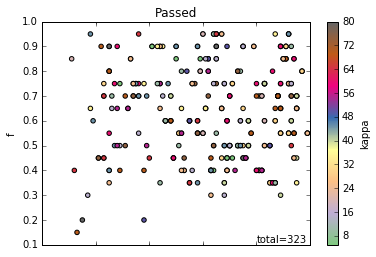

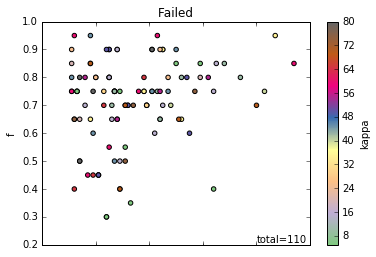

In [38]:
@interact
def by_inc(inc=(0,90,10),precision=(5, 45, 5)):
#     mc_by_inc['inc{0}'.format(inc)].loc[mc_by_inc['inc{0}'.format(inc)]['correct']==True].loc[mc_by_inc['inc{0}'.format(inc)]['precision']<precision].plot.scatter('N', 'f', c='kappa',title='Passed', colormap='Accent')
#     mc_by_inc['inc{0}'.format(inc)].loc[mc_by_inc['inc{0}'.format(inc)]['correct']==False].loc[mc_by_inc['inc{0}'.format(inc)]['precision']<precision].plot.scatter('N', 'f', c='kappa',title='Failed',colormap='Accent')
    #make passed plot
    passed = mc_by_inc['inc{0}'.format(inc)].loc[mc_by_inc['inc{0}'.format(inc)]['precision']<precision]
    passed.plot.scatter('N', 'f', c='kappa',title='Passed', colormap='Accent')
    plt.text(.8,0.01,'total=' + str(len(passed)), transform=plt.gca().transAxes)
    plt.xlim(0,100)
    plt.xlabel('N')
    plt.show()
    #make failed plot
    failed = mc_by_inc['inc{0}'.format(inc)].loc[mc_by_inc['inc{0}'.format(inc)]['precision']>=precision]
    failed.plot.scatter('N', 'f', c='kappa',title='Failed',colormap='Accent')
    plt.text(.8,.01,'total=' + str(len(failed)), transform=plt.gca().transAxes)
    plt.xlim(0,100)
    plt.xlabel('N')
    plt.show()

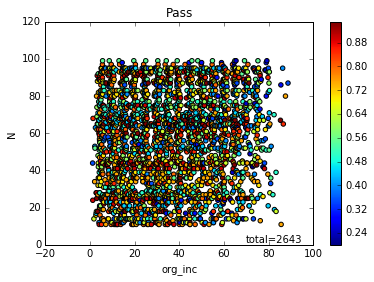

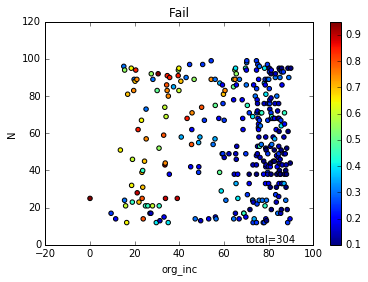

In [39]:
@interact
def pass_fail_plt(sortby=('org_inc', 'f', 'kappa', 'precision'), colorby=('org_inc', 'f', 'kappa', 'precision')):
    mc_inc_sorted = mc_results.loc[mc_results['correct']==True].sort_values('org_inc')
    plt.scatter(mc_inc_sorted[sortby].tolist(), mc_inc_sorted['N'].tolist(), c=mc_inc_sorted[colorby])
    plt.text(.75,.01,'total=' + str(len(mc_inc_sorted)), transform=plt.gca().transAxes)
    plt.title('Pass')
    plt.xlabel(sortby)
    plt.ylabel('N')
    plt.colorbar()
    plt.show()

    mc_inc_sorted = mc_results.loc[mc_results['correct']==False].sort_values('org_inc')
    plt.scatter(mc_inc_sorted[sortby].tolist(), mc_inc_sorted['N'].tolist(), c=mc_inc_sorted[colorby])
    plt.text(.75,.01,'total=' + str(len(mc_inc_sorted)), transform=plt.gca().transAxes)
    plt.title('Fail')
    plt.xlabel(sortby)
    plt.ylabel('N')
    plt.colorbar()
    plt.show()

The accuracy of find_EI's "correction by site" depends strongly on the original mean inclination of the distribution. It does not seem to show a very strong dependence on N (note the rectangular distribution of points on both the "pass" and "fail" graphs above). The explanation for this dependence is as follows: imagine a Fisher distribution at an inclination of 90&deg;. "Squishing" this distribution results in a decrease in the concentration parameter $\kappa$, but because the inclinations are hypothetically being squished equally in all directions, the distribution's mean inclination of 90&deg; does not change. However, due to the decrease in $\kappa$, the effect of outliers on the distribution's elongation is usually amplified. As a result, find_EI corrects the *inclination* to minimize elongation, even though the proper correction does not involve inclination change but rather a change in the concentration parameter. Normally this case would result in a pathological distribution as demonstrated in the example below, but occasionally this is counted as a legitimate correction as we see in the monte carlo simulation.

Additionally, the shallower distributions for which find_EI failed (again, no apparent dependence on N) were generally quite close to being within the bootstrapped correction range and therefore close to passing (see below). It is quite possible that, had this simulation been run with more bootstrap iterations (>100), these same distributions in the "fail" graph would be in the "pass" graph (as long as the bootstrap range shifted in addition to narrowing). 

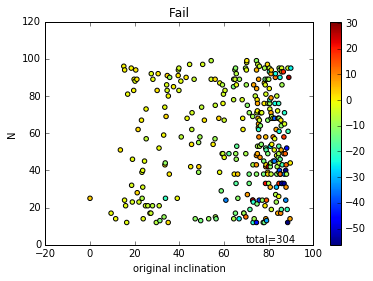

In [40]:
mc_inc_sorted = mc_results.loc[mc_results['correct']==False].sort_values('org_inc')
plt.scatter(mc_inc_sorted['org_inc'].tolist(), mc_inc_sorted['N'].tolist(), 
            c=(0.5*mc_inc_sorted['precision']-abs(mc_inc_sorted['org_inc']-mc_inc_sorted['inc_predict'])))
plt.text(.75,.01,'total=' + str(len(mc_inc_sorted)), transform=plt.gca().transAxes)
plt.title('Fail')
plt.xlabel('original inclination')
plt.ylabel('N')
plt.colorbar()
plt.show()

We can therefore try running a simulation with more bootstrap iterations, or restricting the original inclination to a threshold value. In the simulation below, we have changed the model by increasing the potential N from 100 to 300 and limiting possible inclinations to a maximum of 80&deg;. We do 100 Monte Carlo runs and increase the bootstrap iterations of find_EI to 300. 

With this run, we had a total of 86 failures out of 961 corrections and approximately 639 pathological distributions that were not recorded (!!??), compared to 304 failures out of a total of 2947 corrections for the run before that. (A slight decrease from 10% failure (in the previous run) to 8% failure, although the previous run had more monte carlo iterations (with fewer find_EI bootstrap iterations).) Perhaps it would be a good test to run another model using the default bootstrap iteration of 1000, although this will take quite a long time to run...

In [32]:
#mc_results, path_count = find_EI_montecarlo(100,300,save_as='mc_results_n300_100_300.csv')
#path_count (= 639) (this is over 50% of mc_results' length!!)
print len(mc_results)

961


In [33]:
print 86./961
print 304./2947

0.0894901144641
0.103155751612
